# Predict Customer Churn

The goal of the project is to dig deep into the variables and reach the most information from them to build a relatively accurate and robust classification model.

Source: [kaggle.com/datasets/blastchar/telco-customer-churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))
pd.options.display.float_format = '{:,.4f}'.format

### Load dataset

In [2]:
data = pd.read_csv('data/telco_churn.csv', sep=',')

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7000,151.65,Yes


In [4]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Data Preprocessing

In [5]:
data = data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'})

Change the type of 'TotalCharges' and handle missing values

In [6]:
data['TotalCharges'].value_counts().sort_index()[0:5]

          11
100.2      1
100.25     1
100.35     1
100.4      1
Name: TotalCharges, dtype: int64

In [7]:
data['TotalCharges'] = data['TotalCharges'].replace([data['TotalCharges'].value_counts().sort_index()[0:1].index[0]], 0)

In [8]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

Check the missing values

In [9]:
data.isna().sum()

CustomerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Decode binary variables

In [10]:
for var in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    
    data[var] = np.where(data[var] == 'No', 0, 1)

Edit values of categorical features to support model fitting with dummy variables later with these new column names

In [11]:
for var in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    
    data[var] = data[var].apply(lambda x: x.title().replace(' ',''))
    
data['Contract'] = data['Contract'].map({'Month-to-month': 'MonthToMonth', 'One year': 'OneYear', 'Two year': 'TwoYear'})

data['PaymentMethod'] = data['PaymentMethod'].map({'Bank transfer (automatic)': 'BankTransfer',
                                                   'Credit card (automatic)': 'CreditCard',
                                                   'Electronic check': 'ElectronicCheck',
                                                   'Mailed check': 'MailedCheck'})

Descriptive statistics

In [12]:
def describe_plus(data):
    
    describe = data.describe(include='all').T
    unique = []
    missing = []
    
    for c in list(describe.index):
        
        unique.append(data[c].nunique())
        missing.append(data[c].isna().sum())
        
    describe['unique'] = unique
    describe['missing'] = missing
    describe['count'] = describe['count'].astype(int)
    
    return describe[['count','unique','missing']+list(describe.columns[4:11])]

In [13]:
describe_plus(data)

,count,unique,missing,mean,std,min,25%,50%,75%,max
CustomerID,7043,7043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,7043,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043,2,0,0.1621,0.3686,0.0000,0.0000,0.0000,0.0000,1.0000
Partner,7043,2,0,0.4830,0.4997,0.0000,0.0000,0.0000,1.0000,1.0000
Dependents,7043,2,0,0.2996,0.4581,0.0000,0.0000,0.0000,1.0000,1.0000
Tenure,7043,73,0,32.3711,24.5595,0.0000,9.0000,29.0000,55.0000,72.0000
PhoneService,7043,2,0,0.9032,0.2958,0.0000,1.0000,1.0000,1.0000,1.0000
MultipleLines,7043,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-test split

In [14]:
random_split = 42

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=random_split)

### Feature engineering

#### I. Create grouped variables based on Weight of Evidence

In [15]:
features = train_data.columns[1:20].tolist() #list of raw features

Handle categorical features by decoding values with Weight of Evidence

In [16]:
features_cat = train_data[features].dtypes[train_data[features].dtypes=='object'].index.tolist()

Change the type of categorical features to 'str' from 'int'

In [17]:
for df in [train_data, test_data]:
    
    df[features_cat] = df[features_cat].apply(lambda x: x.astype('str'))

In [18]:
%run -i py/woe_decode_cat_vars.py

In [19]:
cat_table.head(9)

,variable_name,value,woe
0,Gender,Male,0.0358
1,Gender,Female,-0.0376
0,MultipleLines,No,0.0501
1,MultipleLines,Yes,-0.0771
2,MultipleLines,NoPhoneService,0.1098
0,InternetService,FiberOptic,-0.6773
1,InternetService,Dsl,0.4135
2,InternetService,No,1.4639
0,OnlineSecurity,No,-0.6800


In [20]:
train_data.iloc[:,-11:].head()

,DEC_Gender,DEC_MultipleLines,DEC_InternetService,DEC_OnlineSecurity,DEC_OnlineBackup,DEC_DeviceProtection,DEC_TechSupport,DEC_StreamingTV,DEC_StreamingMovies,DEC_Contract,DEC_PaymentMethod
1695,0.0358,-0.0771,0.4135,-0.6800,0.2709,-0.5534,0.6497,-0.1399,-0.3280,0.9557,-0.8054
1095,0.0358,0.0501,-0.6773,-0.6800,-0.6091,-0.5534,-0.6592,-0.1399,-0.3280,-0.7203,-0.8054
3889,0.0358,0.0501,1.4639,1.4639,1.4639,1.4639,1.4639,1.4639,1.4639,0.9557,0.7007
3667,-0.0376,0.0501,-0.6773,-0.6800,-0.6091,0.1959,-0.6592,-0.1399,-0.1786,2.5858,-0.8054
2902,-0.0376,0.0501,-0.6773,0.7367,-0.6091,-0.5534,-0.6592,-0.3620,-0.3280,-0.7203,-0.8054


In [21]:
test_data.iloc[:,-11:].head()

,DEC_Gender,DEC_MultipleLines,DEC_InternetService,DEC_OnlineSecurity,DEC_OnlineBackup,DEC_DeviceProtection,DEC_TechSupport,DEC_StreamingTV,DEC_StreamingMovies,DEC_Contract,DEC_PaymentMethod
185,-0.0376,0.1098,0.4135,-0.6800,-0.6091,-0.5534,-0.6592,-0.3620,-0.3280,-0.7203,-0.8054
2715,0.0358,-0.0771,1.4639,1.4639,1.4639,1.4639,1.4639,1.4639,1.4639,-0.7203,0.5445
3825,-0.0376,0.0501,1.4639,1.4639,1.4639,1.4639,1.4639,1.4639,1.4639,2.5858,0.4265
1807,-0.0376,0.0501,-0.6773,-0.6800,-0.6091,0.1959,-0.6592,-0.3620,-0.3280,-0.7203,-0.8054
132,0.0358,0.0501,0.4135,-0.6800,-0.6091,-0.5534,0.6497,-0.3620,-0.3280,2.5858,0.5445


**Fine classing** step in the process of Credit Risk Scorecard building.

Create equally-sized binned variables, if it is possible. Otherwise use the raw values (categories) as bins.

In this task I would like to create 10 bins for all of the variables.

In [22]:
%run -i py/woe_fine_class.py

In [23]:
fine_stats.head()

,orig_name,grp_name,grp,cnt,bad,good,min,max,pct_total,pct_bad,pct_good,target_rate,woe,iv
0,DEC_Gender,GRP_DEC_Gender,0,2385,644,1741,-0.0376,-0.0376,0.4838,0.4973,0.4790,0.2700,-0.0376,0.0007
1,DEC_Gender,GRP_DEC_Gender,1,2545,651,1894,0.0358,0.0358,0.5162,0.5027,0.5210,0.2558,0.0358,0.0007
0,SeniorCitizen,GRP_SeniorCitizen,0,4140,967,3173,0.0000,0.0000,0.8398,0.7467,0.8729,0.2336,0.1561,0.0197
1,SeniorCitizen,GRP_SeniorCitizen,1,790,328,462,1.0000,1.0000,0.1602,0.2533,0.1271,0.4152,-0.6895,0.0870
0,Partner,GRP_Partner,0,2538,826,1712,0.0000,0.0000,0.5148,0.6378,0.4710,0.3255,-0.3033,0.0506


In [24]:
fine_ivgini.sort_values(by='iv',ascending=False).reset_index(drop=True).head()

,variable_name,iv,gini
0,GRP_DEC_Contract,1.2344,0.4758
1,GRP_Tenure,0.8074,0.4680
2,GRP_DEC_OnlineSecurity,0.6966,0.4062
3,GRP_DEC_TechSupport,0.6538,0.3950
4,GRP_DEC_InternetService,0.5899,0.3825


Keep only those variables where the Information Value is greater than 0.1

In [25]:
features_fine = list(x[4:] for x in fine_ivgini.loc[fine_ivgini['iv'] >= 0.1].sort_values(by='iv',ascending=False).reset_index(drop=True)['variable_name'])

**Coarse classing** step in the process of Credit Risk Scorecard building.

Merge adjacent bins of the previously created grouped variables in the Fine classing step.

In this task I would like to merge and create 5 bins at maximum but it depends on the splitting algorithm. The goal is to choose the best *monotonous* merged version from all of the variables with the highest Information Value.

In [26]:
%run -i py/woe_coarse_class.py

Keep only those variables where the Information Value is greater 0.1 and the merged groups are monotonous.

In [27]:
features_coarse = filter_coarse_vars(features_fine, 0.1, coarse_ivgini)

In [28]:
coarse_stats.loc[coarse_stats['grp_name'].isin(features_coarse)].head()

,orig_name,grp_name,grp,cnt,bad,good,min,max,pct_total,pct_bad,pct_good,target_rate,woe,iv
0,DEC_Contract,C3_DEC_Contract,0,2690,1137,1553,-0.7203,-0.7203,0.5456,0.8780,0.4272,0.4227,-0.7203,0.3247
1,DEC_Contract,C3_DEC_Contract,1,1054,127,927,0.9557,0.9557,0.2138,0.0981,0.2550,0.1205,0.9557,0.1500
2,DEC_Contract,C3_DEC_Contract,2,1186,31,1155,2.5858,2.5858,0.2406,0.0239,0.3177,0.0261,2.5858,0.7597
0,Tenure,C5_Tenure,0,580,334,246,0.0000,2.0000,0.1176,0.2579,0.0677,0.5759,-1.3379,0.2545
1,Tenure,C5_Tenure,1,949,391,558,3.0000,12.0000,0.1925,0.3019,0.1535,0.4120,-0.6764,0.1004


In [29]:
coarse_ivgini.loc[coarse_ivgini['variable_name'].isin(features_coarse)].sort_values(by='iv',ascending=False).reset_index(drop=True).head()

,variable_name,iv,gini,monotonous_woe
0,C3_DEC_Contract,1.2344,0.4758,1
1,C5_Tenure,0.7597,0.4531,1
2,C3_DEC_OnlineSecurity,0.6966,0.4062,1
3,C3_DEC_TechSupport,0.6538,0.3950,1
4,C3_DEC_InternetService,0.5899,0.3825,1


Assign missing values to the most risky category for all variables

In [30]:
miss_dict = {}

for var in features_coarse:
    
    miss_dict[var] = coarse_stats.loc[coarse_stats['grp_name'] == var].sort_values(by='woe',ascending=True).reset_index(drop=True)['grp'][0]

Create Weight of Evidence-decoded variables on the train sample and transfer them to the test sample

In [31]:
%run -i py/woe_decode_transfer_woe.py

In [32]:
train_data.iloc[:,-15:].head()

,W_C5_Tenure,W_C3_DEC_OnlineSecurity,W_C3_DEC_TechSupport,W_C3_DEC_InternetService,W_C3_DEC_OnlineBackup,W_C3_DEC_DeviceProtection,W_C4_DEC_PaymentMethod,W_C3_DEC_StreamingTV,W_C3_DEC_StreamingMovies,W_C3_MonthlyCharges,W_C5_TotalCharges,W_C2_PaperlessBilling,W_C2_Dependents,W_C2_Partner,W_C2_SeniorCitizen
1695,0.5648,-0.6800,0.6497,0.4135,0.2709,-0.5534,-0.8054,-0.1399,-0.3280,-0.3777,0.6548,-0.3369,0.6746,0.3789,0.1561
1095,-1.3379,-0.6800,-0.6592,-0.6773,-0.6091,-0.5534,-0.8054,-0.1399,-0.3280,-0.3777,-1.0605,-0.3369,-0.2319,-0.3033,0.1561
3889,0.1332,1.4639,1.4639,1.4639,1.4639,1.4639,0.7007,1.4639,1.4639,1.2583,-0.6249,0.6004,-0.2319,-0.3033,0.1561
3667,0.1332,-0.6800,-0.6592,-0.6773,-0.6091,0.1959,-0.8054,-0.1399,-0.1786,-0.3777,0.1999,-0.3369,0.6746,0.3789,-0.6895
2902,-0.6764,0.7367,-0.6592,-0.6773,-0.6091,-0.5534,-0.8054,-0.3620,-0.3280,-0.3777,-0.1222,-0.3369,-0.2319,-0.3033,-0.6895


In [33]:
test_data.iloc[:,-30:].head()

,C5_Tenure,W_C5_Tenure,C3_DEC_OnlineSecurity,W_C3_DEC_OnlineSecurity,C3_DEC_TechSupport,W_C3_DEC_TechSupport,C3_DEC_InternetService,W_C3_DEC_InternetService,C3_DEC_OnlineBackup,W_C3_DEC_OnlineBackup,...,C5_TotalCharges,W_C5_TotalCharges,C2_PaperlessBilling,W_C2_PaperlessBilling,C2_Dependents,W_C2_Dependents,C2_Partner,W_C2_Partner,C2_SeniorCitizen,W_C2_SeniorCitizen
185,0,-1.3379,0,-0.6800,0,-0.6592,1,0.4135,0,-0.6091,...,0,-1.0605,1,-0.3369,0,-0.2319,1,0.3789,0,0.1561
2715,3,0.5648,2,1.4639,2,1.4639,2,1.4639,2,1.4639,...,3,0.1999,1,-0.3369,0,-0.2319,0,-0.3033,0,0.1561
3825,3,0.5648,2,1.4639,2,1.4639,2,1.4639,2,1.4639,...,3,0.1999,0,0.6004,1,0.6746,1,0.3789,0,0.1561
1807,0,-1.3379,0,-0.6800,0,-0.6592,0,-0.6773,0,-0.6091,...,0,-1.0605,0,0.6004,0,-0.2319,0,-0.3033,0,0.1561
132,4,1.6814,0,-0.6800,1,0.6497,1,0.4135,0,-0.6091,...,4,0.6548,0,0.6004,0,-0.2319,0,-0.3033,0,0.1561


#### II. Create dummy variables

In [34]:
train_data = train_data.join(pd.get_dummies(train_data[features_cat], drop_first=True))
test_data = test_data.join(pd.get_dummies(test_data[features_cat], drop_first=True))

In [35]:
train_data.iloc[:,-22:].head()

,Gender_Male,MultipleLines_NoPhoneService,MultipleLines_Yes,InternetService_FiberOptic,InternetService_No,OnlineSecurity_NoInternetService,OnlineSecurity_Yes,OnlineBackup_NoInternetService,OnlineBackup_Yes,DeviceProtection_NoInternetService,...,TechSupport_Yes,StreamingTV_NoInternetService,StreamingTV_Yes,StreamingMovies_NoInternetService,StreamingMovies_Yes,Contract_OneYear,Contract_TwoYear,PaymentMethod_CreditCard,PaymentMethod_ElectronicCheck,PaymentMethod_MailedCheck
1695,1,0,1,0,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
1095,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3889,1,0,0,0,1,1,0,1,0,1,...,0,1,0,1,0,1,0,1,0,0
3667,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2902,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
features_dummy = train_data.columns[-22:].tolist()

In [37]:
features_cont = ['Tenure','TotalCharges','MonthlyCharges']

### Feature selection

#### Correlation analysis of WoE-transformed variables

In [38]:
%run -i py/correlation_analysis.py

Correlation matrix with the variables in descending order based on Information Value

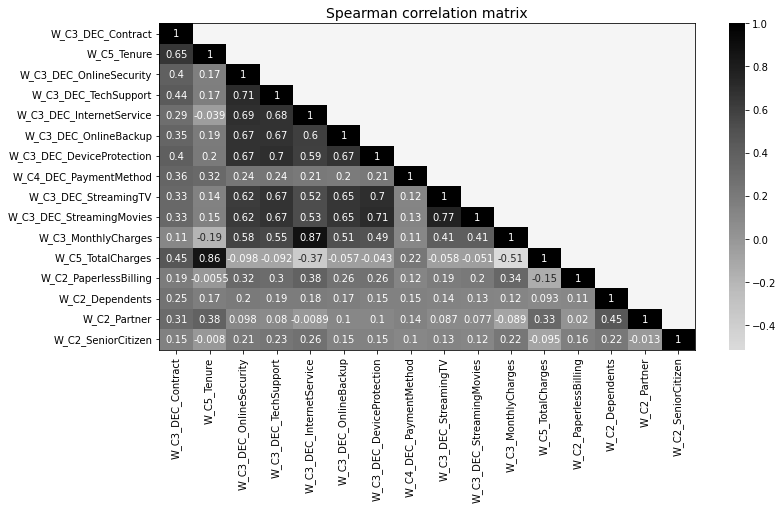

In [39]:
corr_plot(train_data, ['W_'+x for x in features_coarse], method='spearman')

Filter out those variables from highly correlated pairs (higher than 0.5) who have lower Information Value

- Train sample

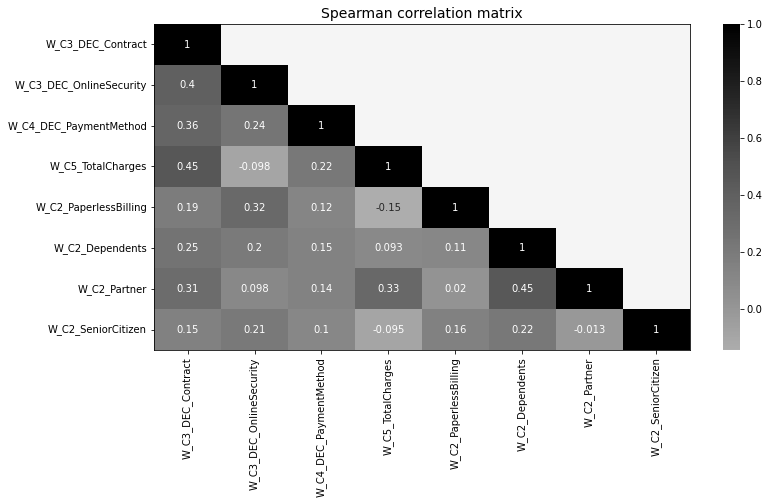

In [40]:
features_woe_corr = filter_by_corr(train_data, ['W_'+x for x in features_coarse], 'spearman')
corr_plot(train_data, features_woe_corr, method='spearman')

- Test sample

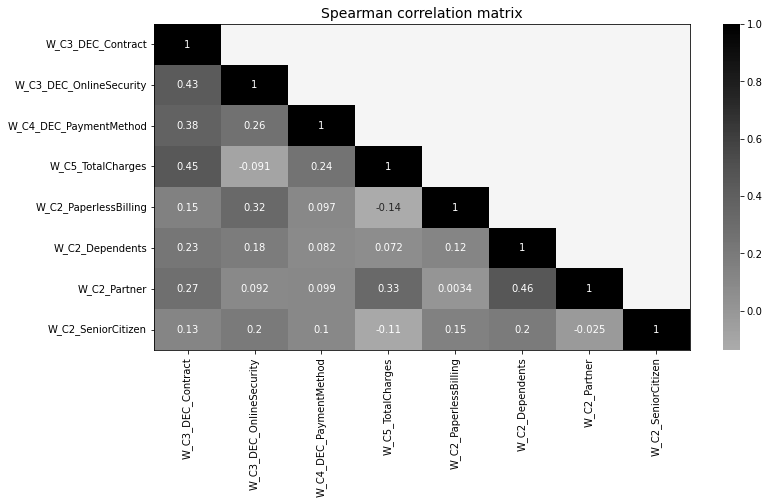

In [41]:
corr_plot(test_data, features_woe_corr, method='spearman')

#### Correlation analysis of continuous and dummy variables

Variable in descending order by their correlation with the target variable

In [42]:
pd.DataFrame(abs(train_data[['Churn']+features_dummy+features_cont].corr(method='pearson').iloc[1:,0]).sort_values(ascending=False)).rename(columns=({'Churn': 'CorrelationWithChurn'}))

,CorrelationWithChurn
Tenure,0.3449
Contract_TwoYear,0.3025
InternetService_FiberOptic,0.3000
PaymentMethod_ElectronicCheck,0.2937
StreamingMovies_NoInternetService,0.2241
InternetService_No,0.2241
OnlineSecurity_NoInternetService,0.2241
OnlineBackup_NoInternetService,0.2241
DeviceProtection_NoInternetService,0.2241
TechSupport_NoInternetService,0.2241


In [43]:
features_corr_sorted = abs(train_data[['Churn']+features_dummy+features_cont].corr(method='pearson').iloc[1:,0]).sort_values(ascending=False).index.tolist()

In [44]:
features_corr_filt = filter_by_corr(train_data, features_corr_sorted, 'pearson')

Filter out those variables from highly correlated pairs (higher than 0.5) who are less correlated with 'Churn'

- Train sample

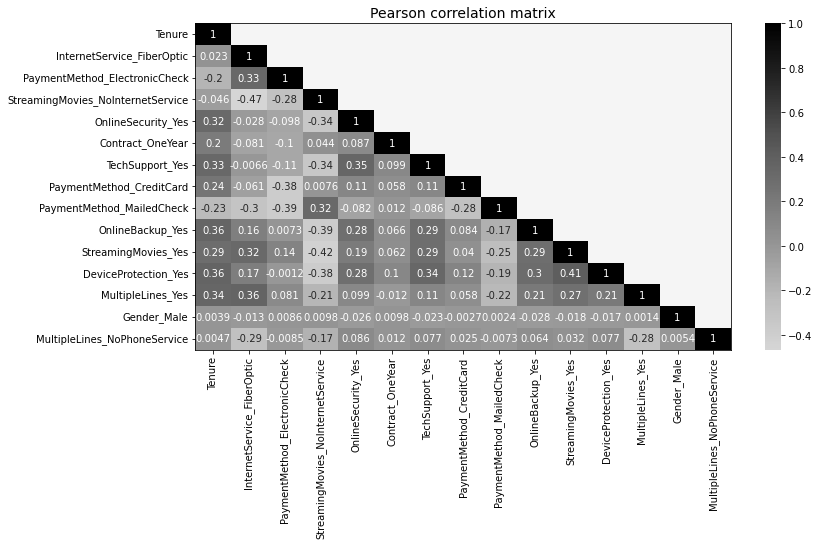

In [45]:
corr_plot(train_data, features_corr_filt, method='pearson')

- Test sample

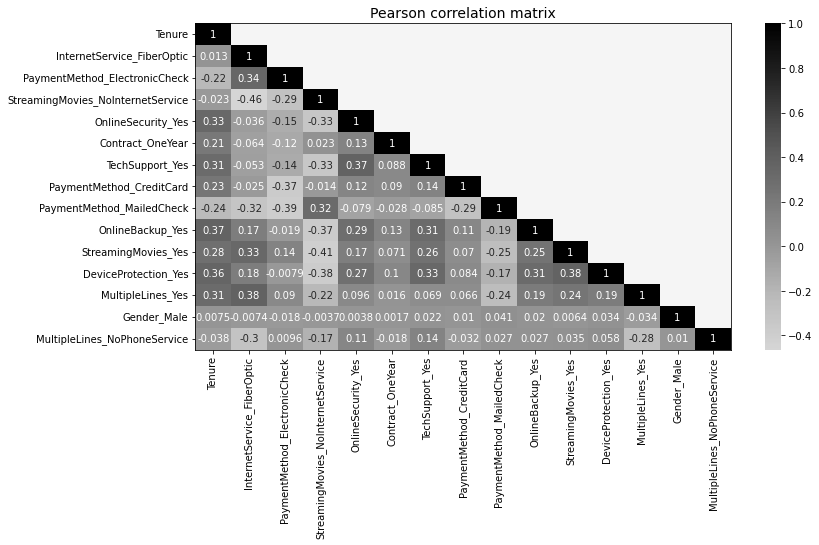

In [46]:
corr_plot(test_data, features_corr_filt, method='pearson')

### Model building

**Logistic regression** from Weight of Evidence-transformed variables

In [47]:
%run -i py/stepwise_selection.py

- Stepwise variable selection for the model

In [48]:
features_stepwise_v1 = stepwise_selection(train_data[features_woe_corr], train_data['Churn'])

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(train_data[features_stepwise_v1], train_data['Churn'])

**Logistic regression** from dummy and raw continuous variables

- Stepwise variable selection for the model

In [49]:
features_stepwise_v2 = stepwise_selection(train_data[features_corr_filt], train_data['Churn'])

logreg_v2 = LogisticRegression().fit(train_data[features_stepwise_v2], train_data['Churn'])

#### Naive Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB

In [51]:
naive = GaussianNB().fit(train_data[features_corr_filt], train_data['Churn'])

Standardize all features to a common scale in order for the algorithms to give equal weights in distance calculations

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data[features_corr_filt])

StandardScaler()

In [53]:
train_data = train_data.join(pd.DataFrame(scaler.transform(train_data[features_corr_filt]), index=train_data.index, columns=['Scaled_'+f for f in features_corr_filt]))
test_data = test_data.join(pd.DataFrame(scaler.transform(test_data[features_corr_filt]), index=test_data.index, columns=['Scaled_'+f for f in features_corr_filt]))

#### Support Vector Classification

In [54]:
from sklearn.svm import SVC

In [55]:
svc = SVC(probability=True).fit(train_data[['Scaled_'+f for f in features_corr_filt]], train_data['Churn'])

#### K Nearest Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

Using cross validation with weighted F1-scoring to find the best hyperparameters

In [58]:
def weighted_f1_scorer(model, X, y):
    
    scores = [f1_score(y,
                       model.predict_proba(X)[:,1] >= t,
                       average='weighted') for t in np.arange(0,1.05,0.05)]
    
    threshold = np.arange(0,1.05,0.05)[np.argmax(scores)]
    
    f = f1_score(y, np.where(model.predict_proba(X)[:,1] >= threshold, 1, 0), average='weighted')

    return f

In [59]:
cv = KFold(n_splits=5, random_state=523, shuffle=True)

In [60]:
params = {'n_neighbors': np.arange(1,11).tolist()}

In [61]:
knn_cv = GridSearchCV(KNeighborsClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[['Scaled_'+f for f in features_corr_filt]], train_data['Churn'])

knn_cv.best_params_

{'n_neighbors': 10}

#### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': [2,3,4,5], 'min_samples_leaf': [int(train_data.shape[0]*0.05)]}

In [64]:
dtree_cv = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[features_corr_filt], train_data['Churn'])

dtree_cv.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 246}

#### Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
params = {'n_estimators': [40,50,60,70,80], 'criterion': ['gini','entropy'], 'max_depth': [2,3,4,5,6], 'min_samples_leaf': [int(train_data.shape[0]*0.05)]}

In [67]:
rf_cv = GridSearchCV(RandomForestClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[features_corr_filt], train_data['Churn'])

rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 246,
 'n_estimators': 60}

#### Gradient Boosting Tree

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

In [69]:
params = {'learning_rate': [0.1, 0.15, 0.20, 0.25], 
              'n_estimators': [40,50,60,70,80], 'max_depth': [2,3,4,5,6],
              'min_samples_leaf': [int(train_data.shape[0]*0.05)]}

In [70]:
gbt_cv = GridSearchCV(GradientBoostingClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[features_corr_filt], train_data['Churn'])

gbt_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 246,
 'n_estimators': 60}

### Model performances

Because of the inbalanced dataset weighted F1-score will be used for model evaluation

Model with the highest weighted F1-score on the test sample will be selected

In [71]:
def weighted_f1_perf(model, train, test, features, target):
    
    scores = [f1_score(train[target], model.predict_proba(train[features])[:,1] >= t,
                       average='weighted') for t in np.arange(0,1.05,0.05)]
    
    threshold = np.arange(0,1.05,0.05)[np.argmax(scores)]
    
    f_train = f1_score(train[target], np.where(model.predict_proba(train[features])[:,1] >= threshold, 1, 0), average='weighted')
    f_test = f1_score(test[target], np.where(model.predict_proba(test[features])[:,1] >= threshold, 1, 0), average='weighted')

    return round(threshold,2), f_train, f_test

In [72]:
performances = {}

In [73]:
performances['LogisticRegression'] = weighted_f1_perf(logreg, train_data, test_data, features_stepwise_v1, 'Churn')
performances['LogisticRegressionV2'] = weighted_f1_perf(logreg_v2, train_data, test_data, features_stepwise_v2, 'Churn')

performances['NaiveBayes'] = weighted_f1_perf(naive, train_data, test_data, features_corr_filt, 'Churn')

performances['SVC'] = weighted_f1_perf(svc, train_data, test_data, ['Scaled_'+f for f in features_corr_filt], 'Churn')
performances['KNearestNeighbors'] = weighted_f1_perf(knn_cv, train_data, test_data, ['Scaled_'+f for f in features_corr_filt], 'Churn')

performances['DecisionTree'] = weighted_f1_perf(dtree_cv, train_data, test_data, features_corr_filt, 'Churn')
performances['RandomForest'] = weighted_f1_perf(rf_cv, train_data, test_data, features_corr_filt, 'Churn')
performances['GradientBoostingTree'] = weighted_f1_perf(gbt_cv, train_data, test_data, features_corr_filt, 'Churn')

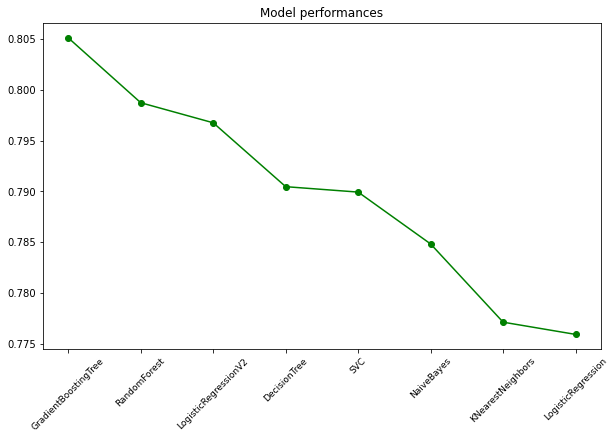

In [74]:
import operator

perf_on_test = {}

for model in performances.keys():
    
    perf_on_test[model] = performances[model][2]
    
perf_on_test = dict(sorted(perf_on_test.items(), key=operator.itemgetter(1),reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(list(perf_on_test.keys()), perf_on_test.values(), color='green', marker='o', ls=None)
labels = ax.get_xticklabels()
plt.setp(labels,rotation=45, horizontalalignment='center',fontsize=9)
plt.title('Model performances')
plt.show()